# Initial imports

In [1]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime
import networkx as nx
import matplotlib.pyplot as plt

#### IMPORT DATA ####

data_source_2014 = 'TrainSet2014_3.pkl'
data_source_2017 = 'CompetitionSet2017_3.pkl'

full_dynamic_graph_sparse, unconnected_vertex_pairs, year_start, years_delta = pickle.load(open(data_source_2014, "rb" ) )

with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)

ground_truth = np.array(unconnected_vertex_pairs_solution)

NUM_OF_VERTICES = 64719 # number of vertices of the semantic net
NUM_OF_EDGES    = full_dynamic_graph_sparse[:, 0].size

# Building adjacency matrix with no time-weights

In [2]:
# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)

adjM = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

adjM_unweighted = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
adjM_unweighted[adjM > 1] = 1 # Not really used, but compresses all links made between two nodes to a single link

#### BUILD DEGREE VECTOR ####

degree_vec             = np.asarray(adjM.sum(1)).flatten()
degree_vec_unweighted  = np.asarray(adjM_unweighted.sum(1)).flatten()

print("Imported", data_source_2014)
print("\nBuilt adjacency matrix with:")
print(" - ", NUM_OF_VERTICES, " vertices")
print(" - ", NUM_OF_EDGES, " edges\n")
print("Found ", np.count_nonzero(degree_vec == 0)," unconnected nodes.")

Imported TrainSet2014_3.pkl

Built adjacency matrix with:
 -  64719  vertices
 -  2278611  edges

Found  27230  unconnected nodes.


# Data analysis

In this challenge we are tasked with ordering a list of 1 million pairs of nodes according to which pairs are most likely to appear. To get a better intuition on how to build our model, it is useful to do some preliminary analysis on the network data with the goal of finding principles underlying the data structure. We start by checking how each pair of nodes to be predicted is currently connected to the network.

In [3]:
pred_degree0 = degree_vec[unconnected_vertex_pairs[:,0]]
pred_degree1 = degree_vec[unconnected_vertex_pairs[:,1]]

# Counts how many links between two nodes with k = 0:
k0 = np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between one nodes with k = 0 and one k > 0:
k1 = np.count_nonzero(pred_degree0 * pred_degree1 == 0) - np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between two nodes with k > 0:
k2 = np.count_nonzero((pred_degree0 * pred_degree1) > 0)

print("Out of 1.000.000 new links:")
print(k0," are between two vertices with degree = 0;")
print(k1," are between one vertex with degree = 0 and one with degree > 0;")
print(k2," are between two vertices with degree > 0s;")

Out of 1.000.000 new links:
265966  are between two vertices with degree = 0;
500060  are between one vertex with degree = 0 and one with degree > 0;
233974  are between two vertices with degree > 0s;


The previous information is useful, because some models are incapable of scoring links that don't belong to the same connected component. Both in the training and competition data there is a significant number of links to be predicted between pairs where at least one of the nodes is disconnected from the network.

We now look at the degree distribution of the whole network. Usually, complex network, it follows a power law []:
\begin{equation}
P(k)\propto k^{-\gamma},
\end{equation}
with $\gamma>2$. Values in the $2<\gamma<3$ range are common, and it is a region of interest since the second moment of the distribution diverges []. Networks with $\gamma\leq 2$ are not well defined given that in such scenario the average degree diverges.
A scale free distribution can be explained from a preferential attachment process, where new nodes that are add the network tend to connect to node with higher degree than nodes with low degree as
\begin{equation}
\Pi(k_i)\propto k_i+B,
\end{equation} 
 with $\Pi(k_i)$ \being the probability that a new node connects to a node with degree $k_i$, and $B$ is just a constant. The higher the value of $B$ is, less relevant the degree of the nodes is. $B$ can be related to gamma as $\gamma=4+B$. Lower values of $\gamma$, means that new nodes added to the network are more likely to be connect to nodes with higher degrees. Although this model doesn’t consider new links that are created between nodes that are already part of the network, the same principle can be easily generalized to such scenario.

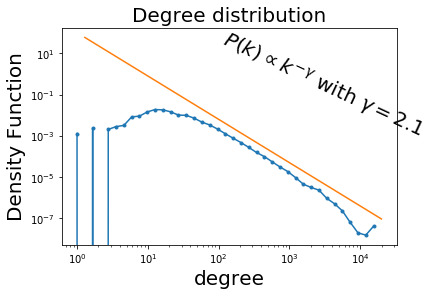

In [4]:
bins=np.logspace(np.log10(1), np.log10(max(degree_vec)+0.001), num=40);

[Y,X]=np.histogram(degree_vec,bins=bins,density=True);

plt.clf();
plt.rcParams['figure.figsize'] = [22, 11]
plt.title('Degree distribution',fontsize=20);
plt.loglog(X[0:-1],Y,'.-');
#plt.loglog(X[1:],10**(2.5)*X[1:]**(-2.3));
plt.loglog(X[1:],10**(2)*X[1:]**(-2.1));
plt.ylabel(r'Density Function',fontsize=20);
plt.xlabel(r'degree',fontsize=20);
plt.annotate(r'$P(k)\propto k^{-\gamma}$ with $\gamma=2.1$',xy=(100, 0.001),rotation=-25,fontsize=20);
plt.show(); 

In this network we find a very low value of $\gamma$, close to 2. Thefore this network strongly favors new connections between nodes with high degress. This makes sense since in new science there is often a tendency to connect popular concepts.

# Defining simple prediction methods

### L3 Method

In [5]:
def l3_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    # Building D^-1/2.
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    degree_vec = np.where(degree_vec == 0, 1, degree_vec) # to avoid division by 0
    sqrt_degree_vec    = 1/np.sqrt(degree_vec)
    sqrt_degree_matrix = ss.diags(sqrt_degree_vec, 0)

    # Computing Ã
    adjM_tilde = sqrt_degree_matrix*adjM*sqrt_degree_matrix;
    
    # Select rows and columns of A corresponding to links to score
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    # Computing P
    p_matrix = (adjM[rows,:]*adjM_tilde*adjM[:,cols]);
    
    # Note that p_matrix has dimensions size(rows)*size(rows). As it happens in the data from the
    # competition the indices in unconnected_vertex_pairs actually only go up to size(rows), which means
    # that we can use those same indices to call values from p_matrix. If that were not the case,
    # we would have to implement a dictionary here to correct the indices before calling values from
    # p_matrix. I checked and in the competition data the same thing happens, and so I didn't implement
    # the dictionary.
    
    # Ordering relevant scores
    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

### Common Neighbours

In [6]:
def cn_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score

    # Select rows and columns of A corresponding to links to score
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    # Computing P
    p_matrix = adjM[rows,:]*adjM[:,cols];
    
    # Note that p_matrix has dimensions size(rows)*size(rows). As it happens in the data from the
    # competition the indices in unconnected_vertex_pairs actually only go up to size(rows), which means
    # that we can use those same indices to call values from p_matrix. If that were not the case,
    # we would have to implement a dictionary here to correct the indices before calling values from
    # p_matrix. I checked and in the competition data the same thing happens, and so I didn't implement
    # the dictionary.
    
    # Ordering relevant scores
    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

### Preferential Attachment

In [7]:
def pa_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    pred_degree_0 = degree_vec[links_to_score[:,0]]
    pred_degree_1 = degree_vec[links_to_score[:,1]]
    
    score_list = pred_degree_0 + pred_degree_1
    
    return score_list/max(score_list)

### Adamic-Adar / Resource Allocation

In [8]:
def aa_method(adjM, links_to_score):
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    non_zero = 0.0001
    r, c  = adjM.nonzero()
    #rD_sp = ss.csr_matrix(((1.0/(degree_vec+non_zero)))[r], (r,c)), shape = (adjM.shape)) # -> RA
    rD_sp = ss.csr_matrix(((1.0/(np.log(degree_vec+non_zero)+non_zero))[r], (r,c)), shape = (adjM.shape)) # -> AA
    adjM_tilde = adjM.multiply(rD_sp)
    
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    p_matrix = adjM[rows,:]*adjM_tilde[:,cols]
    
    p_matrix = p_matrix + p_matrix.T

    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

### Eigenvector Centrality

In [9]:
def ec_method(adjM, links_to_score):

    eigVals, eigVecs = ss.linalg.eigsh(adjM.astype(float), 1)

    eigCent_vec = np.around(np.abs(eigVecs.flatten()), 16) 
    # eigsh has machine errors instead of 0 which introduce randomness in the ranking
    
    eigC_0 = eigCent_vec[unconnected_vertex_pairs[:,0]]
    eigC_1 = eigCent_vec[unconnected_vertex_pairs[:,1]]
    
    score_list = eigC_0 + eigC_1 + 0.9*np.sqrt(eigC_0*eigC_1) # The multiplication gives a small improvement
    
    return score_list/max(score_list)

# Testing the methods on the training data

Skip to the end if running on the competition data.

In [11]:
print(datetime.datetime.now().time())

print("Computing L3 scores...")
score_list_l3 = l3_method(adjM, unconnected_vertex_pairs)
print("Done!")

print("Computing CN scores...")
score_list_cn = cn_method(adjM, unconnected_vertex_pairs)
print("Done!")

print("Computing EC scores...")
score_list_ec = ec_method(adjM, unconnected_vertex_pairs)
print("Done!")

print("Computing AA scores...")
score_list_aa = aa_method(adjM, unconnected_vertex_pairs)
print("Done!")

print("Computing PA scores...")
score_list_pa = pa_method(adjM, unconnected_vertex_pairs)
print("Done!")

print(datetime.datetime.now().time())

16:22:08.035075
Computing L3 scores...
Done!
Computing CN scores...
Done!
Computing EC scores...
Done!
Computing AA scores...
Done!
Computing PA scores...
Done!
16:22:53.944279


## AUC function (for 2014 -> 2017 predictions)

In [12]:
# We use the AUC function from scikit-learn which is faster than the one in the tutorial
from sklearn.metrics import roc_auc_score

with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)

ground_truth = np.array(unconnected_vertex_pairs_solution)

# The scikit-learn AUC function uses the array of scores directly:
AUC_L3_sk = roc_auc_score(ground_truth, score_list_l3)
AUC_CN_sk = roc_auc_score(ground_truth, score_list_cn)
AUC_PA_sk = roc_auc_score(ground_truth, score_list_pa)
AUC_AA_sk = roc_auc_score(ground_truth, score_list_aa)
AUC_EC_sk = roc_auc_score(ground_truth, score_list_ec)

print("Training data AUC:\n")
print("- L3 Method: ", AUC_L3_sk)
print("- CN Method: ", AUC_CN_sk)
print("- AA Method: ", AUC_AA_sk)
print("- PA Method: ", AUC_PA_sk)
print("- EC Method: ", AUC_EC_sk)

Training data AUC:

- L3 Method:  0.6892063232508768
- CN Method:  0.6890970042220121
- AA Method:  0.6892767257750976
- PA Method:  0.8029338991694484
- EC Method:  0.7967909825455262


L3, CN and AA are path based. I've tried combining L3 with CN and CN with AA and saw no improved results. PA and EC are node based. I did see improvements when combining PA with EC.

## Combining results

Let us now see if we can get even better results by combining two of the previous methods with a greedy parameter search. We considered the combination of Common Neighbours with Preferential Attachment. We already saw that PA alone is the best performing method, but this method is completely independent of the node distance inside the network. We now test if the addition of a contribution given by the number of common neighbours is able to improve over PA. We define:

$$scores = a \times scores_\text{CN} + (1-a) \times scores_\text{PA}$$

And search for the optimal "a" between 0 and 1.

In [13]:
step   = 0.01
a_list = np.arange(0, 1 + step, step)
b_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores = a*score_list_ec + (1-a)*score_list_pa
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
a = AUC_save[max_AUC_pos, 0]
combined_scores_0 = a*score_list_ec + (1-a)*score_list_pa

AUC_save = []

for b in b_list:
    combined_scores = b*score_list_aa + (1-b)*combined_scores_0
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([b, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
b = AUC_save[max_AUC_pos, 0]

print("Found max AUC",AUC_save[max_AUC_pos, 1],"for a, b = b", [a, b])

Found max AUC 0.8086158613615134 for a, b = b [0.08, 0.92]


I tried grid searching both parameters at the same time but it would take much longer.

### Trying to optimize the combination

In [ ]:
from scipy.optimize import minimize
from sklearn.metrics import roc_auc_score
import numpy as np

scores_array = np.random.rand(1000000,5)
ground_truth = np.random.randint(0,2,size=(1000000,1))
# To be substituted with the real scores and ground truth vectors

w_init = np.repeat(1,scores_array.shape[1])

def roc_optimize(weights, scores_array, ground_truth):
  combined_scores = 1 / (1 + np.exp(-np.dot(scores_array,weights)))
  return - roc_auc_score(ground_truth, combined_scores)

w_best = minimize(fun=roc_optimize,x0=w_init,args=(scores_array, ground_truth)).x

combined_scores = combined_scores = 1 / (1 + np.exp(-np.dot(scores_array,w_best)))
AUC = roc_auc_score(ground_truth, combined_scores)
print('Optimized AUC: ', AUC)

# Building a time-weighted adjacency matrix

So far we have completely ignored the time stamps attached to each link in the data. These time stamps correspond to the date when each link was added to the network, counted as the total number of days since a reference date. In order to include this information in the model, we chose to use this information directly as a weight on each link. We consider the following hypothesis:

- The most important links are the very old ones and the very recent ones. The reasoning is that very old links correspond to early connections between concepts, which have had a lot of time to mature and become rooted in the field. The very recent links correspond to the latest connections between concepts, corresponding to the current hot-topic being studied in the field.

In order to quantify and test this hypothesis we normalized the time stamp to a value t between 0 and 1, and tested different polynomial functions f(t) producing weights in the links.

### Grid searching optimal polynomial parameters (don't run, saved below):

In [56]:
# Normalizing the time-stamps
times = full_dynamic_graph_sparse[:, 2] - full_dynamic_graph_sparse[:, 2].min()
t     = times/times.max()

def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

non_zero  = 0.001
delta_a   = 1.0
delta_x0  = 0.1
delta_x1  = 0.01

b_range  = np.arange(2, 11, 2)
a_range  = np.arange(1, 5 + delta_a, delta_a)
x0_range = np.arange(0.0 + non_zero, 0.5 + non_zero + delta_x0, delta_x0)
x1_range = np.arange(0.45, 0.55, delta_x1)

AUC_save = []

for b in b_range:
    print("Current power:",b)
    for x0 in x0_range:
        for a in a_range:
            for x1 in x1_range:
                        
                times_norm = polynomial(t, x0, x1, a, b)
                times_norm = np.concatenate([times_norm, times_norm])
                adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
                score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)
                AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)
                        
                AUC_save.append([AUC_PA_sk_time, x0, x1, a, b])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,0].argmax()

print("Found max AUC", AUC_save[max_AUC_pos, 0],"for:")
print(AUC_save[max_AUC_pos, 1:5])

#x0 = 0.0
#x1 = 0.45
#a  = 3
#b  = 6

Current power: 2
Current power: 4
Current power: 6
Current power: 8
Current power: 10
Found max AUC 0.8136713130746505 for:
[1.0e-03 4.5e-01 3.0e+00 6.0e+00]


### Running methods with time weights:

The various sets of polynomial parameters have been optimized with the PA method. I've tried also optimizing different parameters for the CN method, which ended up having better performance on the training data, but then reduced performance on the competition. Doing some sort of time-weighting seems to help overall, but going too deep into optimizing the nuances of the function for each method seems to have random effect on the competition performance.

Using scikit-learn AUC function:
- PA Method:  0.8136720715779155
- EC Method:  0.8113634753827339
- AA Method:  0.6882913832630044


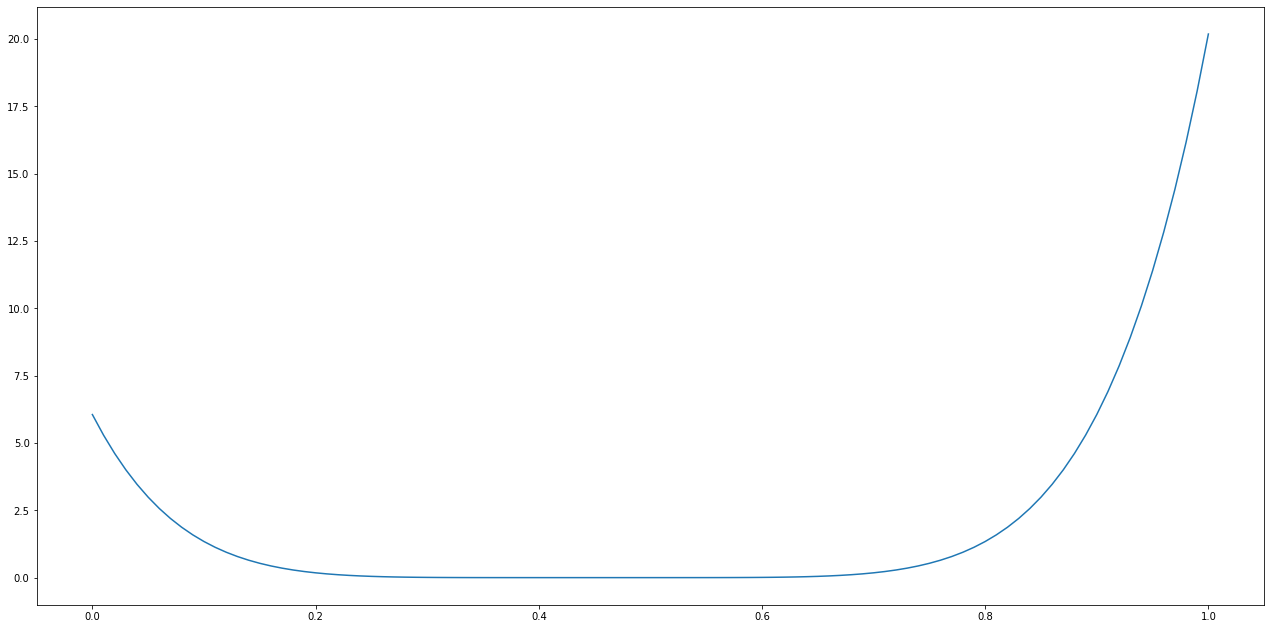

In [16]:
def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

# Normalizing the time-stamps
times = full_dynamic_graph_sparse[:, 2] - full_dynamic_graph_sparse[:, 2].min()
t     = times/times.max()

delta = 0.01
x = np.arange(0, 1+delta, delta)

x0 = 0.0
x1 = 0.45
a  = 3
b  = 6

plt.plot(x , polynomial(x, x0, x1, a, b))

# Polynomial function of the time-stamps
times_norm = polynomial(t, x0, x1, a, b)
times_norm = np.concatenate([times_norm, times_norm])

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)
score_list_ec_time = ec_method(adjM_weighted, unconnected_vertex_pairs)
score_list_aa_time = aa_method(adjM_weighted, unconnected_vertex_pairs)

AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)
AUC_EC_sk_time = roc_auc_score(ground_truth, score_list_ec_time)
AUC_AA_sk_time = roc_auc_score(ground_truth, score_list_aa_time)

print("Using scikit-learn AUC function:")
print("- PA Method: ", AUC_PA_sk_time)
print("- EC Method: ", AUC_EC_sk_time)
print("- AA Method: ", AUC_AA_sk_time)

In [17]:
step   = 0.01
a_list = np.arange(0, 1 + step, step)
b_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores = a*score_list_ec_time + (1-a)*score_list_pa_time
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
a = AUC_save[max_AUC_pos, 0]
combined_scores_0 = a*score_list_ec_time + (1-a)*score_list_pa_time

AUC_save = []

for b in b_list:
    combined_scores = b*score_list_aa_time + (1-b)*combined_scores_0
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([b, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()
b = AUC_save[max_AUC_pos, 0]

print("Found max AUC",AUC_save[max_AUC_pos, 1],"for a, b = ", [a, b])

Found max AUC 0.8183933060106223 for a, b =  [0.39, 0.9500000000000001]


# Running on the competition data (2017)

In [126]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime

#### IMPORT DATA ####

data_source_2014 = 'TrainSet2014_3.pkl'
data_source_2017 = 'CompetitionSet2017_3.pkl'

full_dynamic_graph_sparse, unconnected_vertex_pairs, year_start, years_delta = pickle.load(open(data_source_2017, "rb" ) )

NUM_OF_VERTICES = 64719 # number of vertices of the semantic net
NUM_OF_EDGES    = full_dynamic_graph_sparse[:, 0].size

# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)

# Normalizing the time-stamps
times = full_dynamic_graph_sparse[:, 2]
t     = times/times.max()

# Polynomial function of the time-stamps

x0 = 0.0
x1 = 0.45
a  = 3
b  = 6

times_norm = polynomial(t, x0, x1, a, b)
times_norm = np.concatenate([times_norm, times_norm_pa])

# Building unweighted adjacency matrix
adjM = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

In [127]:
#score_list_l3 = l3_method(adjM, unconnected_vertex_pairs)
#score_list_cn = cn_method(adjM, unconnected_vertex_pairs)
#score_list_pa = pa_method(adjM, unconnected_vertex_pairs)

score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)
score_list_ec_time = ec_method(adjM_weighted, unconnected_vertex_pairs)
score_list_aa_time = aa_method(adjM_weighted, unconnected_vertex_pairs)

a = 0.39
b = 0.95

combined_scores_time = b*score_list_aa_time + (1-b)*(a*score_list_ec_time + (1-a)*score_list_pa_time)

sorted_predictions = np.argsort(-1.0*combined_scores_time)

# Exporting a submission file

In [128]:
import json

# Current submissions done:
# Bacalhau à Brás - L3 method unweighted
# Bacalhau com Todos - PA method unweighted
# Bacalhau à Gomes de Sá - CN + PA method unweighted
# Bacalhau à Lagareiro - CN + PA method time-weighted with -0.05 + (2*(x-0.48))**6

# Save the results for submission.
submit_file = "bacalhau_a_lagareiro_V2.json"

all_idx_list_float=list(map(float, sorted_predictions))
with open(submit_file, "w", encoding="utf8") as json_file:
    json.dump(all_idx_list_float, json_file)
    
print("Solution stored as "+submit_file+".\nLooking forward to your submission.")

Solution stored as bacalhau_a_lagareiro_V2.json.
Looking forward to your submission.


# Final tests submission history:

- Submission 1 - PA + CN:
 
 - PA: x0 = -0.02, x1 = 0.45, a = 2.0, b = 6
 - CN: x0 = 0.5, x1 = 0.45, a = 2, b = 2
 - a = 0.94, AUC: 0.9178064905656237
 
- Submission 2 - PA + CN:
 
 - PA & CN: x0 = -0.02, x1 = 0.45, a = 2.0, b = 6
 - a = 0.96, AUC: 0.9178522719428891
 
- Submission 3 - PA + CN:
 
 - PA: x0 = -0.02, x1 = 0.45, a = 2.0, b = 6
 - CN Normal
 - a = 0.93, AUC: 0.9172168868259193
 
- Submission 4 - PA + CN:
 
 - PA & CN: x0 = 0.0, x1 = 0.45, a = 3, b = 6
 - a = 0.96, AUC: 0.9178639557362034
 
- Submission 5 - PA + AA: 
 
 - PA & AA: x0 = 0.0, x1 = 0.45, a = 3, b = 6
 - a = 0.95, AUC: 0.9183816983951876   <--------- BEST SO FAR
 
- Submission 6 - PA + AA:
 
 - PA & AA: x0 = 0.3, x1 = 0.45, a  = 4, b  = 8
 - a = 0.96, AUC: 0.9181785713306634
 
- Submission 7 - PA + CN: (optimized from new training)
 
 - PA & CN: x0 = 0.0, x1 = 0.47, a  = 5, b  = 6
 - a = 0.95, AUC: 0.9179633080564475
 
- Submission 8 - PA + AA: (optimized from new training)
 
 - PA & AA: x0 = 0.0, x1 = 0.47, a  = 5, b  = 6
 - a = 0.95, AUC: 0.9183130435938832

- Submission 9 - PA + EC + AA:
 
 - PA & AA: x0 = 0.0, x1 = 0.45, a = 3, b = 6
 - a = 0.39, b = 0.95, AUC: 0.9180640118564981
 - b * aa + (1-b) * (a * ec + (1-a) * pa)